d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


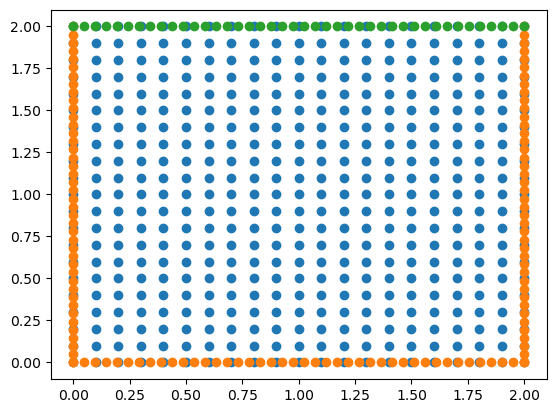

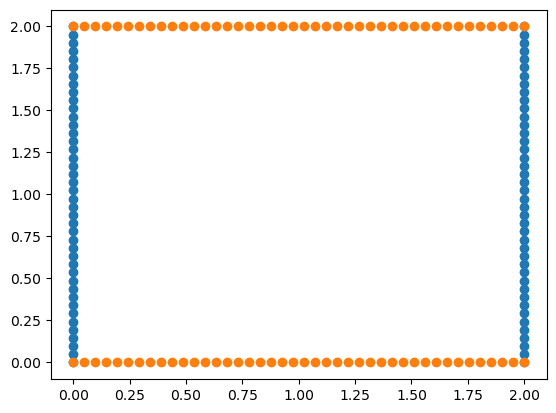

In [1]:
import sys
sys.path.append('../')

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.geom import line_linspace
import user_funn.plot

np.random.seed(1)
torch.manual_seed(2)

# STEP1 data generate
batch_num = 1
nx = 21

field = D2Field([0,2],[0,2])
pde_batch_size = nx * nx
pde_input = field.get_field_mesh([nx,nx])
pde_output = np.zeros([pde_batch_size,3])

points_num_per_line = nx * 2 #每条边上用点数量
bc_left_input = line_linspace([0,0],[0,2], points_num_per_line)
bc_up_input = line_linspace([0,2],[2,2], points_num_per_line)
bc_right_input = line_linspace([2,2],[2,0], points_num_per_line)
bc_down_input = line_linspace([2,0],[0,0], points_num_per_line)

bc_uv_zero_input = np.vstack([bc_left_input, bc_down_input, bc_right_input])
bc_uv_up_input = bc_up_input 
bc_dpdx_zero_input = np.vstack([bc_left_input, bc_right_input])
bc_dpdy_zero_input = np.vstack([bc_up_input, bc_down_input])

bc_uv_zero_output = np.zeros([bc_uv_zero_input.shape[0], 2])
bc_uv_up_output = np.zeros([bc_uv_up_input.shape[0], 2])
bc_uv_up_output[:,0] = 1
bc_dpdx_zero_output = np.zeros([bc_dpdx_zero_input.shape[0], 1])
bc_dpdy_zero_output = np.zeros([bc_dpdy_zero_input.shape[0], 1])

bc_uv_zero_batchsize = bc_uv_zero_input.shape[0]
bc_uv_up_batchsize = bc_uv_up_input.shape[0]
bc_dpdx_zero_batchsize = bc_dpdx_zero_input.shape[0] 
bc_dpdy_zero_batchsize = bc_dpdy_zero_input.shape[0] 

user_funn.plot.scatter_2d_cloud_point_kind([pde_input, bc_uv_zero_input, \
    bc_uv_up_input])

user_funn.plot.scatter_2d_cloud_point_kind([bc_dpdx_zero_input, \
    bc_dpdy_zero_input])


In [2]:
from user_funn.pde import diff

MU = 0.1
loss_fn = torch.nn.MSELoss()

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True

    x = x_in[:,[0]]
    y = x_in[:,[1]]
    x_use = torch.cat((x,y),dim = 1)
    U = model(x_use)
    p = U[:,[0]]
    u = U[:,[1]]
    v = U[:,[2]]

    dudx = diff(u,x)
    dudy = diff(u,y)
    dvdx = diff(v,x)
    dvdy = diff(v,y)
    dpdx = diff(p,x)
    dpdy = diff(p,y)

    du2dx2 = diff(dudx,x)
    du2dy2 = diff(dudy,y)
    dv2dx2 = diff(dvdx,x)
    dv2dy2 = diff(dvdy,y)

    eq1 = u * dudx + v * dudy + dpdx - MU * (du2dx2 + du2dy2)
    eq2 = u * dvdx + v * dvdy + dpdy - MU * (dv2dx2 + dv2dy2)
    eq3 = dudx + dvdy
    loss_val = loss_fn(eq1, y_real[:,[0]]) + loss_fn(eq2, y_real[:,[1]]) + \
        loss_fn(eq3, y_real[:,[2]])
    return loss_val


from user_funn.bc import data_loss_factory
bc_uv_zero_loss = data_loss_factory(loss_fn, [1,2])
bc_uv_up_loss = data_loss_factory(loss_fn, [1,2])

cloud_point_data = [
    [pde_input, pde_output],
    [bc_uv_zero_input, bc_uv_zero_output],
    [bc_uv_up_input, bc_uv_up_output],
    ]

solver = CloudPointSolver(
    cloud_point_data,
    [pde_loss, bc_uv_zero_loss, bc_uv_up_loss],
    model = ForwardNetwork([2, 64, 64, 64, 64, 3]),
    optimizer = "adam",
    batchsize = [pde_batch_size, bc_uv_zero_batchsize, bc_uv_up_batchsize]
    )

for i in range(10000):
    solver.train_step()
    if i % 1000 == 0:
        solver.test_step(print_flag=True)
print('train over')

loss is [0.00071418 0.00980145 0.39421254 0.40472817]
loss is [0.00211621 0.01689791 0.00361363 0.02262775]
loss is [0.00125684 0.01232484 0.00339499 0.01697666]
loss is [0.00081092 0.00974558 0.00239871 0.01295522]
loss is [0.00075444 0.0080838  0.00158725 0.01042549]
loss is [0.00035962 0.00710058 0.00165656 0.00911676]
loss is [0.00056909 0.00621622 0.00232448 0.0091098 ]
loss is [0.00037405 0.00649662 0.00149304 0.0083637 ]
loss is [0.00047223 0.00667291 0.00127425 0.00841938]
loss is [0.00038501 0.00581041 0.00186142 0.00805685]
train over


0.13375942683176506
0.1341464359182668
0.13668919974431784
U error is 0.1238151714900998


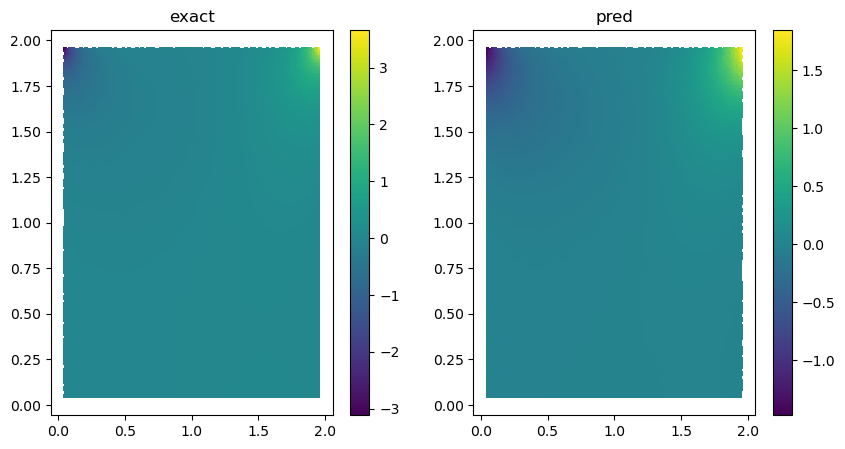

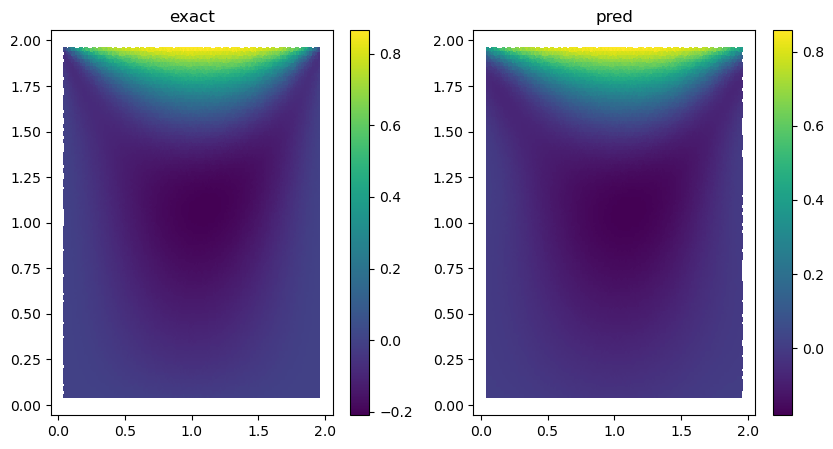

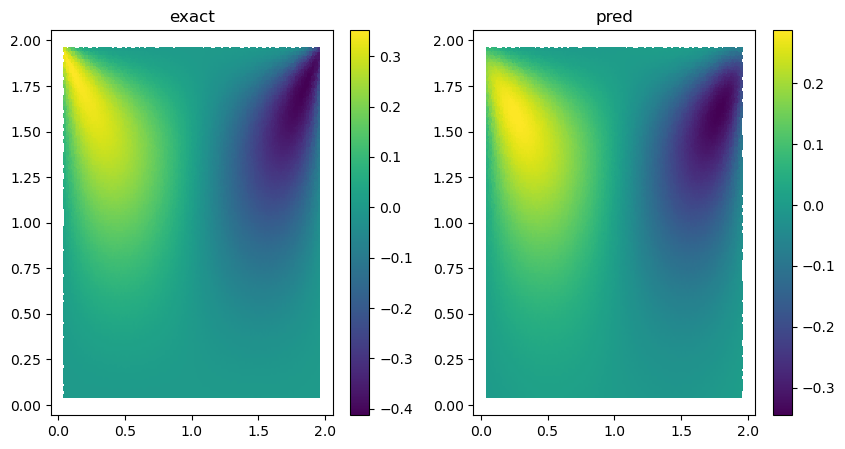

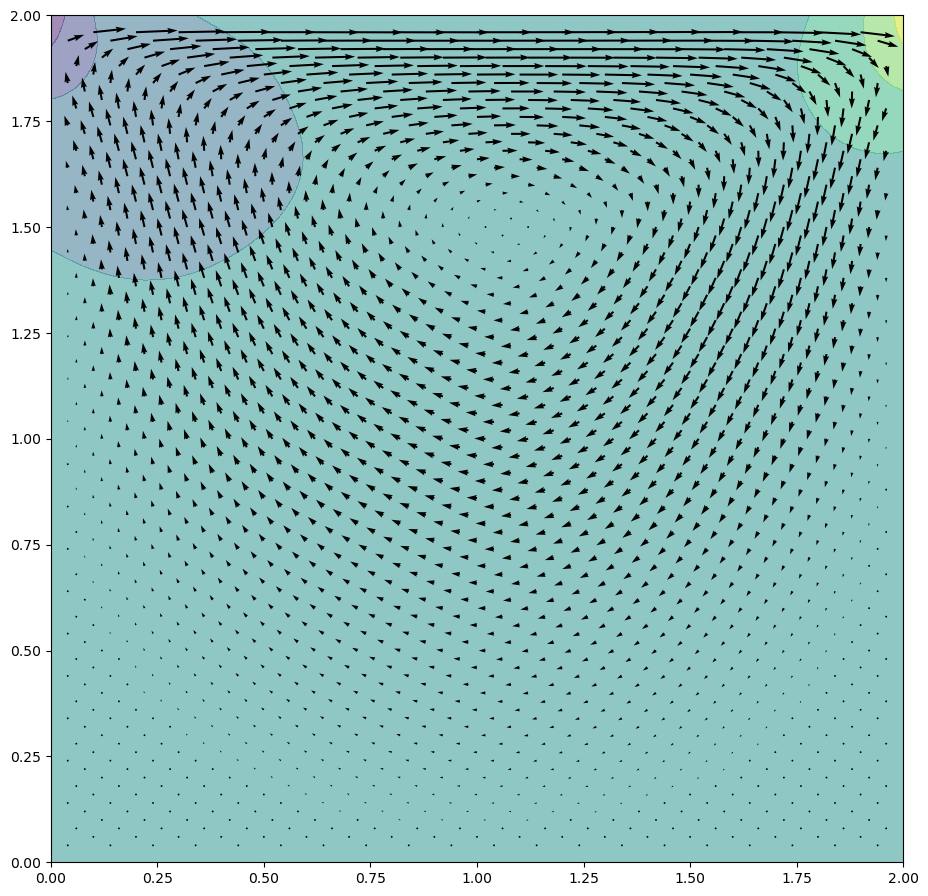

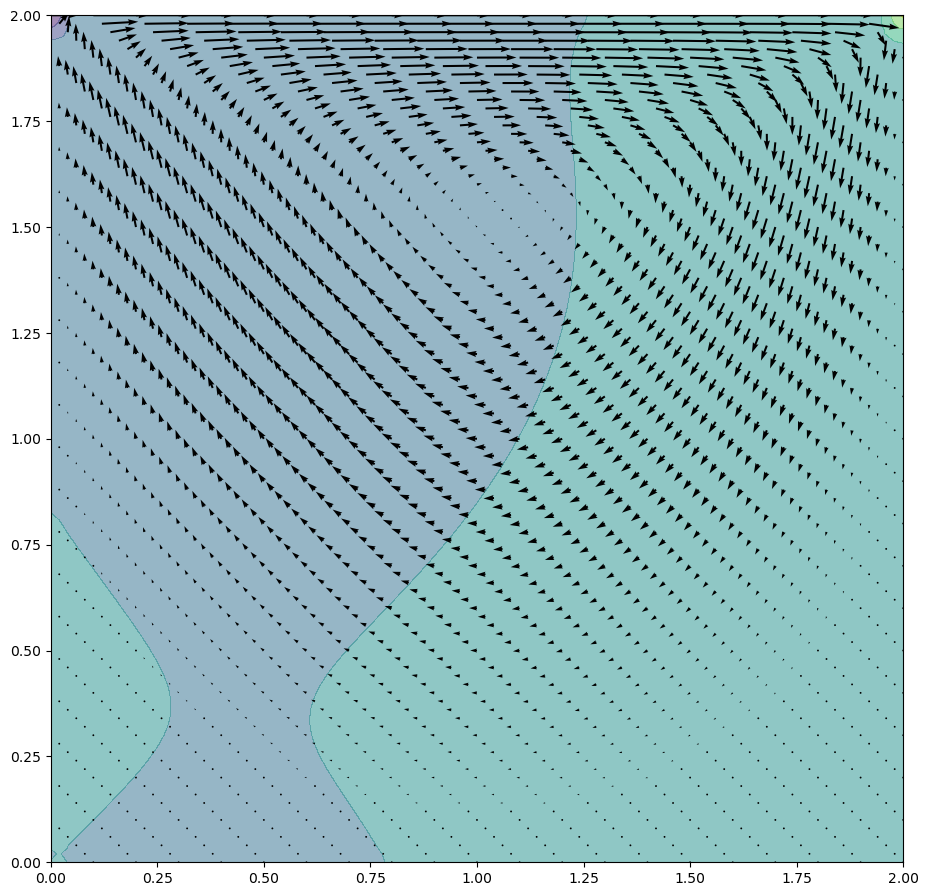

In [3]:
from user_funn.paraview_read import read2D_paraview_csv
exact_x,exact_y,exact_p,exact_u,exact_v=read2D_paraview_csv('../data/t=5,nu=0.1all_result.csv',5)
filter = (exact_x>=0.04) & (exact_x<=1.96) & (exact_y>=0.04) & (exact_y<=1.96) 

plot_input = np.array([exact_x,exact_y]).T
plot_output = solver.model_eval(plot_input)
plot_p = plot_output[:,0]
plot_u = plot_output[:,1]
plot_v = plot_output[:,2]

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_U(x,y,u_exact,u_pred):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize =[10,5] )

    triang = tri.Triangulation(x,y)
    tpc = ax1.tripcolor(triang,u_exact , shading='flat')
    fig.colorbar(tpc,ax=ax1)
    ax1.set_title('exact')

    tpc = ax2.tripcolor(triang,u_pred , shading='flat')
    fig.colorbar(tpc,ax=ax2)
    ax2.set_title('pred')
    print(np.mean(np.abs(u_exact-u_pred))/np.mean(np.abs(u_exact)))

x = plot_input[:,0]
y = plot_input[:,1]
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_p[filter]-np.mean(exact_p), plot_p[filter]-np.mean(plot_p))
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_u[filter], plot_u[filter])
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_v[filter], plot_v[filter])

plot_x = plot_input[:,0]
plot_y = plot_input[:,1]
plt.figure(figsize=(11, 11))
plt.tricontourf(plot_x, plot_y, plot_p,alpha=0.5, cmap=cm.viridis)
plt.quiver(plot_x[filter][::5], plot_y[filter][::5],plot_u[filter][::5],plot_v[filter][::5])

plt.figure(figsize=(11, 11))
plt.tricontourf(plot_x, plot_y, exact_p,alpha=0.5, cmap=cm.viridis)
plt.quiver(plot_x[::5], plot_y[::5],exact_u[::5],exact_v[::5])

def calc_U_error(exact_u,pred_u,exact_v,pred_v):
    error_u = np.abs(exact_u-pred_u)
    error_v = np.abs(exact_v-pred_v)
    error_U = np.sqrt(error_u**2 + error_v**2)
    org_U = np.sqrt(exact_u**2 + exact_v**2)
    return error_U/np.mean(org_U)

print('U error is', np.mean(calc_U_error(exact_u,plot_u,exact_v,plot_v)))